<a href="https://colab.research.google.com/github/robertosgpontes/osem/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Formulação do Problema

O problema apresentado pode ser formulado através de uma

\begin{equation}
	\max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i}
\end{equation}
e
\begin{equation}
\min \sum_{i=1}^{n}{C_iX_i}
\end{equation}


Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [234]:
% pip install pulp

https://www.supplychaindataanalytics.com/multi-objective-linear-optimization-with-pulp-in-python/

https://pythonhealthcare.org/tag/pareto-front/

In [235]:
# Python libraries used to solve the problem Linear Programing
import pulp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [236]:
NUM_ITER = 1000

In [237]:
def create_x_variables():
    x1 = pulp.LpVariable("x1",lowBound = 0) 
    x2 = pulp.LpVariable("x2",lowBound = 0)
    x3 = pulp.LpVariable("x3",lowBound = 0) 
    x4 = pulp.LpVariable("x4",lowBound = 0) 
    return np.array([[x1], [x2], [x3], [x4]]) 

In [238]:
def load_model(lpm, A, X, b):
    Ax = A.dot(X)

    for i in range(0,4):
        lpm += Ax[i,0] <= b[i,0]

    lpm += Ax[4,0] == b[4,0]

    for i in range(5,7):
        lpm += Ax[i,0] >= b[i,0]

    return lpm

In [239]:
f_real = lambda c, x: c.dot(x)

In [240]:
f = lambda c, x: f_real(c, x)[0]

In [241]:
sig = lambda sigma: 1/(1 + np.exp(sigma*(np.linspace(0, NUM_ITER, NUM_ITER)-(NUM_ITER/2))))

In [242]:
def f_alpha(alpha, f1, f2):
  return (alpha*f1 + (1-alpha)*f2)

In [243]:
# Variáveis do modelo

A1 = np.array([11.444, 0.047, 1.523, 0.095])
A2 = np.array([0.899, 0.0, 0.926, 0.073]) 
A3 = np.array([0.00106, 0.00010, 0.00021, 0.00006])
C = np.array([np.around(A1 - (A2 + A3), 5),
              [1.41, 4.99, 2.41, 6.24]])
A = np.array([  [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 1, 0],
                [1, 1, 1, 1],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])

b = np.array([[557],[1143],[1577],[1700],[10310],[160],[6990]])

In [244]:
CIni = C

In [245]:
CIni

array([[10.54394,  0.0469 ,  0.59679,  0.02194],
       [ 1.41   ,  4.99   ,  2.41   ,  6.24   ]])

In [246]:
#MinMax
CMinMax = (C - C.min()) / (C.max() - C.min())

In [247]:
CMinMax

array([[1.        , 0.00237217, 0.05463315, 0.        ],
       [0.13191979, 0.47215929, 0.22695875, 0.59095799]])

In [248]:
CStandardization = (C - C.mean()) / C.std()

In [249]:
CStandardization

array([[ 2.08568285, -0.92932991, -0.77138773, -0.93649905],
       [-0.53781345,  0.4904522 , -0.25058841,  0.8494835 ]])

In [250]:
C = CStandardization

# Approach 1: Solution with Hierarchical Methodology

Maximizing for one objective, then adding it as a constraint and solving for the other objective

## 1.1. First Step

\begin{equation}
S_1 = \max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [251]:
linearProblem = pulp.LpProblem("First_Objective_Max",pulp.LpMaximize)

X = create_x_variables()

linearProblem += f(C[0], X)

linearProblem = load_model(linearProblem, A, X, b)

#linearProblem.writeLP('modelStep1.lp')

solution = linearProblem.solve()

In [252]:
print(linearProblem)

First_Objective_Max:
MAXIMIZE
2.085682854808582*x1 + -0.9293299108830332*x2 + -0.7713877319710578*x3 + -0.9364990479570715*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous



In [253]:
print("#1 - " + str(pulp.LpStatus[solution])+" ; max value = "+str(pulp.value(linearProblem.objective))+
      " ; x1_opt = "+str(pulp.value(X[0][0]))+
      " ; x2_opt = "+str(pulp.value(X[1][0]))+
      " ; x3_opt = "+str(pulp.value(X[2][0]))+
      " ; x4_opt = "+str(pulp.value(X[3][0])))

#1 - Optimal ; max value = -7721.501360217454 ; x1_opt = 557.0 ; x2_opt = 8610.0 ; x3_opt = 1143.0 ; x4_opt = 0.0


In [254]:
f1_max = pulp.value(linearProblem.objective)

## 1.1. Second Step


\begin{equation}
\min \sum_{i=1}^{n}{C_iX_i}
\end{equation}
Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} \geq S_1
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [255]:
linearProblem2 = pulp.LpProblem("Second_Objective_Min",pulp.LpMinimize)

X = create_x_variables()

linearProblem2 += f(C[1], X)

linearProblem2 = load_model(linearProblem2, A, X, b)

linearProblem2 += f(C[0], X) >= f1_max

#linearProblem2.writeLP('modelStep2.lp')

solution2 = linearProblem2.solve()

In [256]:
print(linearProblem2)

Second_Objective_Min:
MINIMIZE
-0.5378134547283229*x1 + 0.49045219932043604*x2 + -0.2505884116979432*x3 + 0.8494835031084105*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

_C8: 2.08568285481 x1 - 0.929329910883 x2 - 0.771387731971 x3
 - 0.936499047957 x4 >= -7721.50136022

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous



In [257]:
print(str(pulp.LpStatus[solution2])+" ; max value = "+str(pulp.value(linearProblem2.objective))+
      " ; x1_opt = "+str(pulp.value(X[0][0]))+
      " ; x2_opt = "+str(pulp.value(X[1][0]))+
      " ; x3_opt = "+str(pulp.value(X[2][0]))+
      " ; x4_opt = "+str(pulp.value(X[3][0])))

Optimal ; max value = 3636.8087872945293 ; x1_opt = 557.0 ; x2_opt = 8610.0 ; x3_opt = 1143.0 ; x4_opt = 0.0


# 2. Solution with ...

\begin{equation}
	\max  \alpha\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} - (1-\alpha)\sum_{i=1}^{n}{C_iX_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}

In [258]:
def run_models(f_alphas):
  solution_lst = []
  i = 0
  for alpha in f_alphas:
    model = pulp.LpProblem("MultiObjetivo", pulp.LpMaximize)

    X = create_x_variables()

    model += f_alpha(alpha, f(C[0], X), -f(C[1], X))

    model = load_model(model, A, X, b)

    solution = model.solve()

    X2 = np.array([pulp.value(X[0][0]), 
                    pulp.value(X[1][0]), 
                    pulp.value(X[2][0]), 
                    pulp.value(X[3][0])])
    
    solution_lst.append([i,
                    alpha,
                    str(pulp.LpStatus[solution])] +
                    X2.tolist() +
                    [pulp.value(model.objective),
                    f_real(C[0], X2),
                    f_real(C[1], X2)]
                    )
    i += 1
    
  return pd.DataFrame(solution_lst, columns=["iter","alpha","status","x1","x2", "x3", "x4", "obj_value", "f1", "f2"])

In [259]:
alpha_lin = np.linspace(0, 1, NUM_ITER)

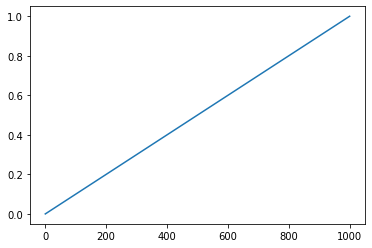

In [260]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_lin)

In [261]:
df_solution_lin = run_models(alpha_lin)

In [262]:
df_solution_lin

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.000000,Optimal,557.0,8610.0,1143.0,0.0,-3636.808787,-7721.50136,3636.808787
1,1,0.001001,Optimal,557.0,8610.0,1143.0,0.0,-3640.897569,-7721.50136,3636.808787
2,2,0.002002,Optimal,557.0,8610.0,1143.0,0.0,-3644.986350,-7721.50136,3636.808787
3,3,0.003003,Optimal,557.0,8610.0,1143.0,0.0,-3649.075131,-7721.50136,3636.808787
4,4,0.004004,Optimal,557.0,8610.0,1143.0,0.0,-3653.163913,-7721.50136,3636.808787
...,...,...,...,...,...,...,...,...,...,...
995,995,0.995996,Optimal,557.0,8610.0,1143.0,0.0,-7705.146235,-7721.50136,3636.808787
996,996,0.996997,Optimal,557.0,8610.0,1143.0,0.0,-7709.235016,-7721.50136,3636.808787
997,997,0.997998,Optimal,557.0,8610.0,1143.0,0.0,-7713.323798,-7721.50136,3636.808787
998,998,0.998999,Optimal,557.0,8610.0,1143.0,0.0,-7717.412579,-7721.50136,3636.808787


In [263]:
alpha_sig_004 = sig(-0.004)

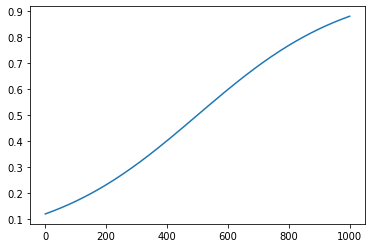

In [264]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_004)

In [265]:
df_solution_sig_004 = run_models(alpha_sig_004)

In [266]:
df_solution_sig_004

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.119203,Optimal,557.0,8610.0,1143.0,0.0,-4123.716078,-7721.50136,3636.808787
1,1,0.119624,Optimal,557.0,8610.0,1143.0,0.0,-4125.435881,-7721.50136,3636.808787
2,2,0.120046,Optimal,557.0,8610.0,1143.0,0.0,-4127.160930,-7721.50136,3636.808787
3,3,0.120470,Optimal,557.0,8610.0,1143.0,0.0,-4128.891237,-7721.50136,3636.808787
4,4,0.120895,Optimal,557.0,8610.0,1143.0,0.0,-4130.626810,-7721.50136,3636.808787
...,...,...,...,...,...,...,...,...,...,...
995,995,0.879105,Optimal,557.0,8610.0,1143.0,0.0,-7227.683337,-7721.50136,3636.808787
996,996,0.879530,Optimal,557.0,8610.0,1143.0,0.0,-7229.418911,-7721.50136,3636.808787
997,997,0.879954,Optimal,557.0,8610.0,1143.0,0.0,-7231.149217,-7721.50136,3636.808787
998,998,0.880376,Optimal,557.0,8610.0,1143.0,0.0,-7232.874267,-7721.50136,3636.808787


In [267]:
alpha_sig_06 = sig(-0.06)

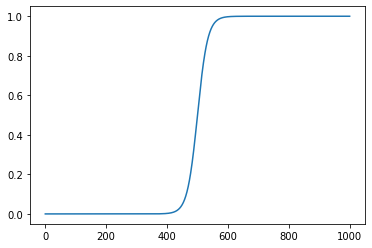

In [268]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_06)

In [269]:
df_solution_sig_06 = run_models(alpha_sig_06)

In [270]:
df_solution_sig_06

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,9.357623e-14,Optimal,557.0,8610.0,1143.0,0.0,-3636.808787,-7721.50136,3636.808787
1,1,9.936863e-14,Optimal,557.0,8610.0,1143.0,0.0,-3636.808787,-7721.50136,3636.808787
2,2,1.055196e-13,Optimal,557.0,8610.0,1143.0,0.0,-3636.808787,-7721.50136,3636.808787
3,3,1.120513e-13,Optimal,557.0,8610.0,1143.0,0.0,-3636.808787,-7721.50136,3636.808787
4,4,1.189873e-13,Optimal,557.0,8610.0,1143.0,0.0,-3636.808787,-7721.50136,3636.808787
...,...,...,...,...,...,...,...,...,...,...
995,995,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,-7721.501360,-7721.50136,3636.808787
996,996,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,-7721.501360,-7721.50136,3636.808787
997,997,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,-7721.501360,-7721.50136,3636.808787
998,998,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,-7721.501360,-7721.50136,3636.808787


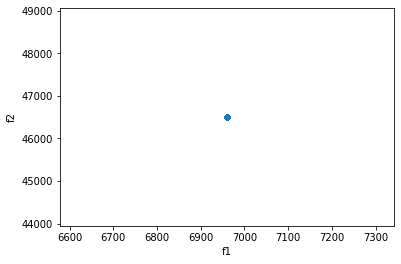

In [137]:
df_solution_sig_06.plot.scatter(x='f1', y='f2')